In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
from cbrain.imports import *
from cbrain.utils import *
from matplotlib.animation import FuncAnimation
from IPython.display import SVG, HTML, FileLink

/export/home/srasp/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
DATA_DIR = '/beegfs/DATA/pritchard/srasp/'
%ls {DATA_DIR}

nnatmonly_fbp8_D002_andkua/         nonsp_4k/
nnatmonly_fbp8_D003_andkua/         nonsp_andkua/
nnatmonly_fbp8_D004_andkua_allfix/  old_3kw1/
nnatmonly_fbp8_D004_andkua_msefix/  old_data/
nnatmonly_fbp8_D004_andkua_nofix/   preprocessed_data/
nnatmonly_fbp8_D004_andkua_qfix/    sp32fbp_andkua/
nnatmonly_fbp8_D005_andkua_nofix/   sp8fbp_3kw1/
nnfullphy_fbp32_E002_andkua/        sp8fbp_4k/
nnfullphy_fbp8_E001_andkua/         sp8fbp_andkua/
nnfullphy_std8_A003/                tmp/
nonsp_3kw1/


In [4]:
exps_ak = ['sp8fbp_andkua', 'nnatmonly_fbp8_D004_andkua_allfix', 'nonsp_andkua']

In [5]:
# %%time
# h0s = {e : xr.open_mfdataset(f'{DATA_DIR}{e}/*.h0.0000-*', decode_times=False) for e in exps_ak}
# h1s = {e : xr.open_mfdataset(f'{DATA_DIR}{e}/*.h1.0000-*', decode_times=False) for e in exps_ak}

In [6]:
# with open('./saved_ds.pkl', 'wb') as f:
#     pickle.dump((h0s, h1s), f)

In [7]:
with open('./saved_ds.pkl', 'rb') as f:
    h0s, h1s = pickle.load(f)

In [8]:
def compare(func, exps, ref=None, title=None, hs=h0s, **kwargs):
    npanels = len(exps) if ref is None else len(exps) + 1
    ncols=min(3, npanels); nrows=int(np.ceil(npanels/ncols))
    fig, axs = plt.subplots(nrows, ncols, figsize=(13.5, 4*nrows));
    if ref is None:
        [func(hs[e]).plot(ax=ax, **kwargs) for e, ax in zip(exps, axs.flat)]
        [ax.set_title(e) for e, ax in zip(exps, axs.flat)]
    else:
        yi = kwargs['yincrease'] if 'yincrease' in kwargs.keys() else None
        func(hs[ref]).plot(ax=axs.flat[0], yincrease=yi); axs.flat[0].set_title(ref)
        [(func(hs[e])-func(h0s[ref]).values).plot(ax=ax, **kwargs) for e, ax in zip(exps, axs.flat[1:])]
        [ax.set_title(f'{e} - {ref}') for e, ax in zip(exps, axs.flat[1:])]
    if title is None: plt.tight_layout()
    else: fig.suptitle(title); plt.tight_layout(rect=(0, 0, 1, 0.95))
    return fig, axs

In [9]:
def compare_line(func, exps, ax=None, legend=True, **kwargs):
    if ax is None: fig, ax = plt.subplots(figsize=(6, 5))
    [func(h0s[e]).plot(ax=ax, label=e, **kwargs) for e in exps]
    if legend: ax.legend()

In [10]:
pagewidth = 8. # Inches

## Mean climate and parameterized tendencies

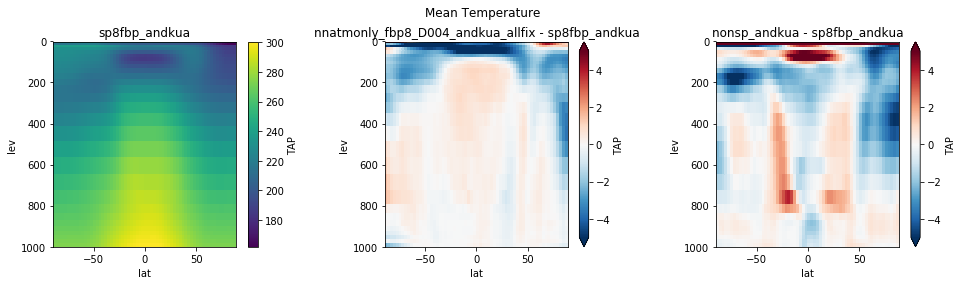

In [13]:
compare(lambda d: d['TAP'].sel(time=slice(30, None)).mean(('time', 'lon')), exps_ak[1:], ref=exps_ak[0], 
        yincrease=False, vmin=-5, vmax=5, cmap='RdBu_r', title='Mean Temperature');

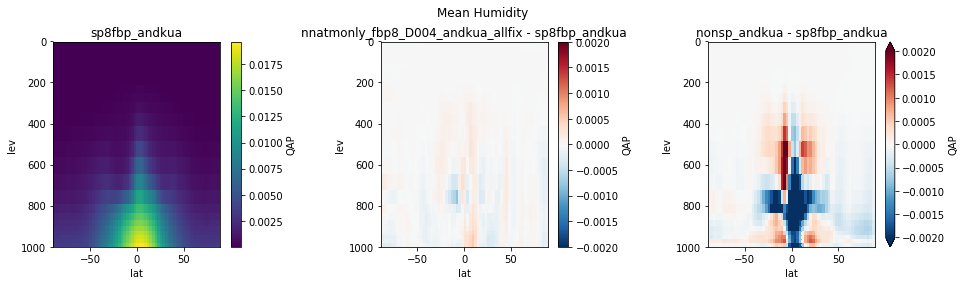

In [17]:
compare(lambda d: d['QAP'].sel(time=slice(30, None)).mean(('time', 'lon')), exps_ak[1:], ref=exps_ak[0], 
        yincrease=False, vmin=-0.002, vmax=0.002, cmap='RdBu_r', title='Mean Humidity');

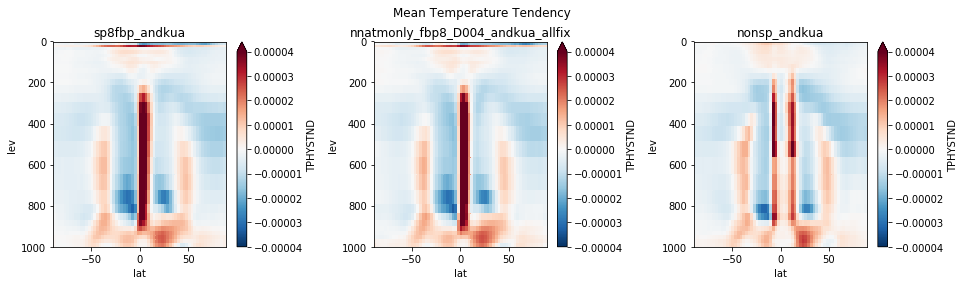

In [15]:
compare(lambda d: d['TPHYSTND'].sel(time=slice(30, None)).mean(('time', 'lon')), exps_ak, 
        yincrease=False, vmin=-4e-5, vmax=4e-5, cmap='RdBu_r', title='Mean Temperature Tendency');

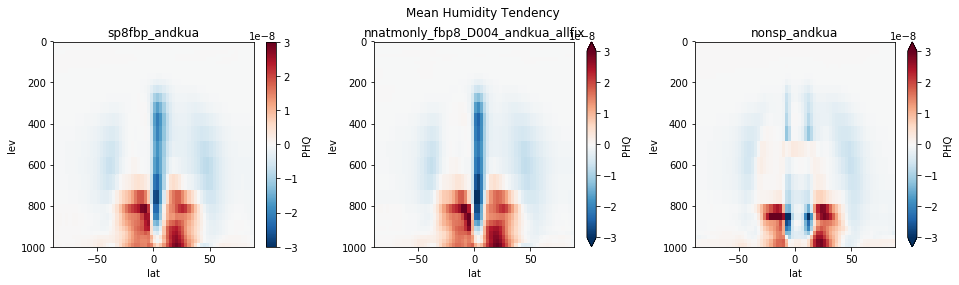

In [18]:
compare(lambda d: d['PHQ'].sel(time=slice(30, None)).mean(('time', 'lon')), exps_ak, 
        yincrease=False, vmin=-3e-8, vmax=3e-8, cmap='RdBu_r', title='Mean Humidity Tendency');

### Final plot for paper

In [66]:
temps = [h0s[e]['TAP'].sel(time=slice(30, None)).isel(lev=slice(3,None)).mean(('time', 'lon')).compute() for e in exps_ak]

In [67]:
temps[1] = temps[1] - temps[0]
temps[2] = temps[2] - temps[0]

In [69]:
lats = h0s[exps_ak[0]].lat.values

In [70]:
gw = h0s[exps_ak[0]].gw.isel(time=0)

In [71]:
gwsum = np.cumsum(gw.values)

In [72]:
for t in temps: t['lat'] = gwsum

In [76]:
label_lats = [-60, -30, 0, 30, 60]

In [77]:
gw_lats = [np.interp(l, lats, gwsum) for l in label_lats]

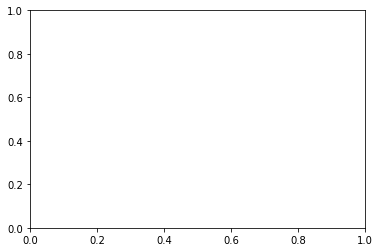

In [63]:
_, ax = plt.subplots()

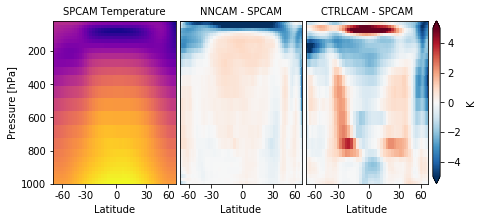

In [116]:
fig, axs = plt.subplots(1, 3, figsize=(pagewidth, 3))
temps[0].plot(ax=axs[0], yincrease=False, add_colorbar=False, cmap='plasma')
temps[1].plot(ax=axs[1], yincrease=False, add_colorbar=False, vmin=-5, vmax=5, cmap='RdBu_r')
im = temps[2].plot(ax=axs[2], yincrease=False, add_colorbar=False, vmin=-5, vmax=5, cmap='RdBu_r')
[ax.set_xticks(gw_lats) for ax in axs.flat]; [ax.set_xticklabels(label_lats) for ax in axs.flat]; 
[ax.set_yticks([]) for ax in axs.flat[1:]]; [ax.set_ylabel('') for ax in axs.flat[1:]];
axs[0].set_ylabel('Pressure [hPa]'); [ax.set_xlabel('Latitude') for ax in axs.flat]
plt.subplots_adjust(wspace=0.03)
cb = fig.colorbar(im, ax=axs.flat, pad=0.01, extend='both'); cb.set_label('K')
axs[0].set_title('SPCAM Temperature', fontsize=10)
axs[1].set_title('NNCAM - SPCAM', fontsize=10)
axs[2].set_title('CTRLCAM - SPCAM', fontsize=10);

In [95]:
tphys = [h0s[e]['TPHYSTND'].sel(time=slice(30, None)).isel(lev=slice(3,None)).mean(('time', 'lon')).compute() for e in exps_ak]

In [98]:
for t in tphys: t['lat'] = gwsum

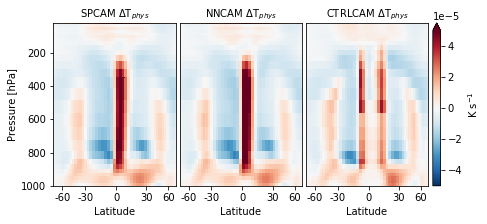

In [117]:
fig, axs = plt.subplots(1, 3, figsize=(pagewidth, 3))
tphys[0].plot(ax=axs[0], yincrease=False, add_colorbar=False, vmin=-5e-5, vmax=5e-5, cmap='RdBu_r')
tphys[1].plot(ax=axs[1], yincrease=False, add_colorbar=False, vmin=-5e-5, vmax=5e-5, cmap='RdBu_r')
im = tphys[2].plot(ax=axs[2], yincrease=False, add_colorbar=False, vmin=-5e-5, vmax=5e-5, cmap='RdBu_r')
[ax.set_xticks(gw_lats) for ax in axs.flat]; [ax.set_xticklabels(label_lats) for ax in axs.flat]; 
[ax.set_yticks([]) for ax in axs.flat[1:]]; [ax.set_ylabel('') for ax in axs.flat[1:]];
axs[0].set_ylabel('Pressure [hPa]'); [ax.set_xlabel('Latitude') for ax in axs.flat]
plt.subplots_adjust(wspace=0.03)
cb = fig.colorbar(im, ax=axs.flat, pad=0.01, extend='max'); cb.set_label(r'K s$^{-1}$')
cb.formatter.set_powerlimits((0, 0)); cb.update_ticks()
cb.ax.yaxis.set_offset_position('left') 
axs[0].set_title(r'SPCAM $\Delta$T$_{phys}$', fontsize=10)
axs[1].set_title(r'NNCAM $\Delta$T$_{phys}$', fontsize=10)
axs[2].set_title(r'CTRLCAM $\Delta$T$_{phys}$', fontsize=10);

## Variability

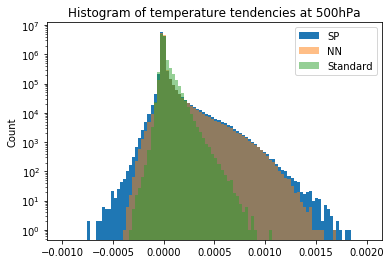

In [44]:
[h1s[e]['TPHYSTND'].sel(time=slice(30, None)).sel(lev=500, method='nearest').plot(
    range=(-1e-3, 2e-3), bins=100, label=e, alpha=1. if i==0 else 0.5) 
 for i, e in enumerate(exps_ak)];
plt.legend(['SP', 'NN', 'Standard']); plt.yscale('log')
plt.title('Histogram of temperature tendencies at 500hPa');

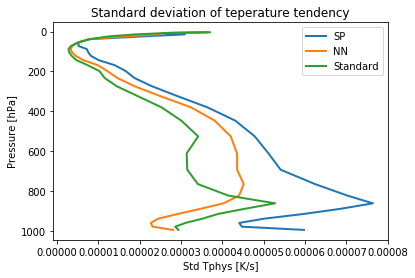

In [19]:
[plt.plot(h1s[e]['TPHYSTND'].sel(time=slice(30, None)).std(('time', 'lon')).mean('lat'), h1s[e].lev, label=e, lw=2)
 for i, e in enumerate(exps_ak)];
plt.legend(['SP', 'NN', 'Standard']); plt.gca().invert_yaxis()
plt.title('Standard deviation of teperature tendency'); plt.ylabel('Pressure [hPa]'); plt.xlabel('Std Tphys [K/s]');

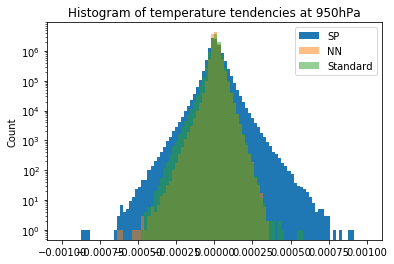

In [45]:
[h1s[e]['TPHYSTND'].sel(time=slice(30, None)).sel(lev=950, method='nearest').plot(
    range=(-1e-3, 1e-3), bins=100, label=e, alpha=1. if i==0 else 0.5) 
 for i, e in enumerate(exps_ak)];
plt.legend(['SP', 'NN', 'Standard']); plt.yscale('log')
plt.title('Histogram of temperature tendencies at 950hPa');

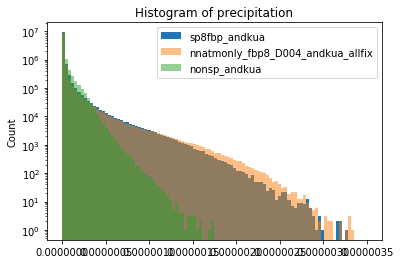

In [41]:
[h1s[e]['PRECT'].sel(time=slice(30, None)).plot(
    range=(0, 3.5e-6), bins=100, label=e, alpha=1. if i==0 else 0.5) 
 for i, e in enumerate(exps_ak)];
plt.legend(); plt.yscale('log')
plt.title('Histogram of precipitation');

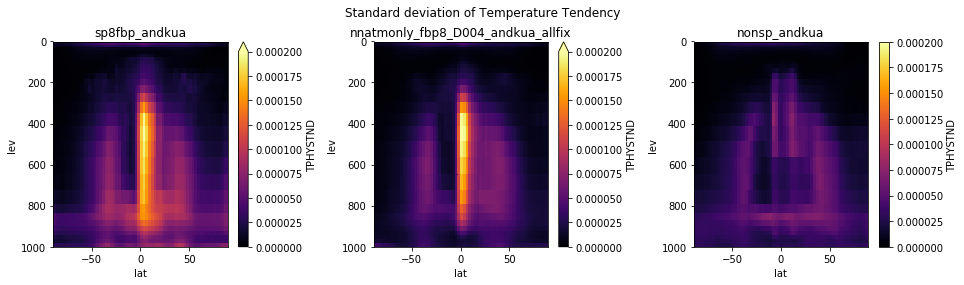

In [57]:
compare(lambda d: d['TPHYSTND'].sel(time=slice(30, 90)).std(('time', 'lon')), exps_ak, hs=h1s,
        yincrease=False, vmin=0, vmax=2e-4, cmap='inferno', title='Standard deviation of Temperature Tendency');

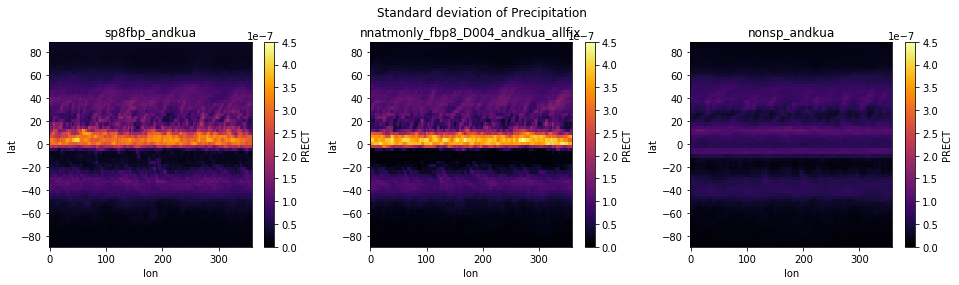

In [54]:
compare(lambda d: d['PRECT'].sel(time=slice(30, None)).std(('time')), exps_ak, hs=h1s,
        vmin=0, vmax=4.5e-7, cmap='inferno', title='Standard deviation of Precipitation');

### Plot for paper

In [21]:
stds = [h1s[e]['TPHYSTND'].sel(time=slice(30, 32)).isel(lev=slice(3, None)).std(('time', 'lon')).mean('lat').compute()
        for i, e in enumerate(exps_ak)];

In [22]:
levs = h1s[exps_ak[0]].lev[3:].values

In [25]:
colors = ['dodgerblue', 'firebrick', 'darkgreen']

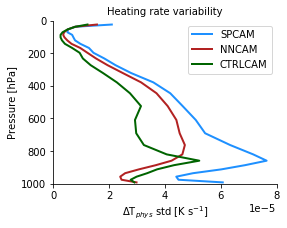

In [31]:
fig, ax = plt.subplots(figsize=(pagewidth/2, 3))
[plt.plot(stds[i], levs, label=e, c=colors[i], lw=2) for i, e in enumerate(['SPCAM', 'NNCAM', 'CTRLCAM'])]
ax.legend(fontsize=10)
sns.despine()
ax.set_xlabel(r'$\Delta$T$_{phys}$ std [K s$^{-1}$]'); ax.set_ylabel(r'Pressure [hPa]')
ax.set_title('Heating rate variability', fontsize=10)
ax.ticklabel_format(axis='x', scilimits=(0, 0))
ax.set_ylim(0, 1000); ax.set_xlim(0, 0.8e-4)
ax.invert_yaxis()

In [32]:
prects = [h1s[e]['PRECT'].sel(time=slice(30, 60)).plot(range=(0, 3.5e-6), bins=100, label=e) 
          for i, e in enumerate(exps_ak)];
plt.close('all')

In [34]:
prects[0][0].shape, prects[0][1].shape

((100,), (101,))

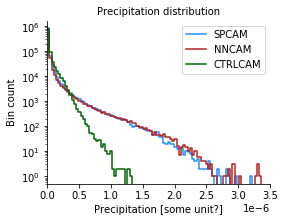

In [42]:
fig, ax = plt.subplots(figsize=(pagewidth/2, 3))
[ax.step(prects[i][1][:-1], prects[i][0], label=e, c=colors[i], where='post') 
 for i, e in enumerate(['SPCAM', 'NNCAM', 'CTRLCAM'])]
ax.set_yscale('log')
ax.legend(fontsize=10)
sns.despine()
ax.set_xlabel(r'Precipitation [some unit?]'); ax.set_ylabel(r'Bin count')
ax.set_title('Precipitation distribution', fontsize=10)
ax.ticklabel_format(axis='x', scilimits=(0, 0))
#ax.set_ylim(0, 1000); 
ax.set_xlim(0, prects[0][1][-1]);

## Generalization to new SSTs

In [62]:
DATA_DIR_3KW1 = '/beegfs/DATA/pritchard/srasp/old_3kw1/'
%ls {DATA_DIR_3KW1}

nnatmonly_fbp8_D001_3kw1_old/  nnatmonly_fbp8_D003_3kw1_old/  nonsp_3kw1_old/
nnatmonly_fbp8_D002_3kw1_old/  nnfullphy_fbp8_E001_3kw1_old/  sp8fbp_3kw1_old/


In [67]:
exps_3kw1 = ['sp8fbp_3kw1_old', 'nnatmonly_fbp8_D002_3kw1_old', 'nonsp_3kw1_old']

In [68]:
for e in exps_3kw1:
    h0s[e] =  xr.open_mfdataset(f'{DATA_DIR_3KW1}{e}/*.h0.0000-*', decode_times=False)
    h1s[e] =  xr.open_mfdataset(f'{DATA_DIR_3KW1}{e}/*.h1.0000-*', decode_times=False)

In [69]:
for d in h0s.values(): 
    d['vTAP'] = vint(d, 'TAP', C_P); d['vQAP'] = vint(d, 'QAP', L_V)
    d['vTPHY'] = vint(d, 'TPHYSTND', C_P); d['vPHQ'] = vint(d, 'PHQ', L_V)

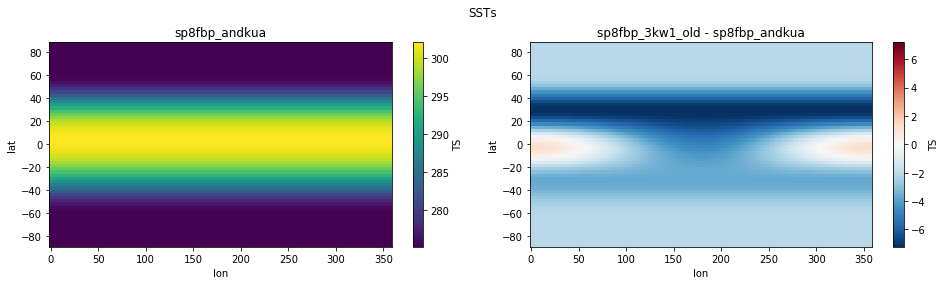

In [71]:
compare(lambda d: d['TS'].isel(time=0), [exps_3kw1[0]], ref=exps_ak[0],
        title='SSTs');

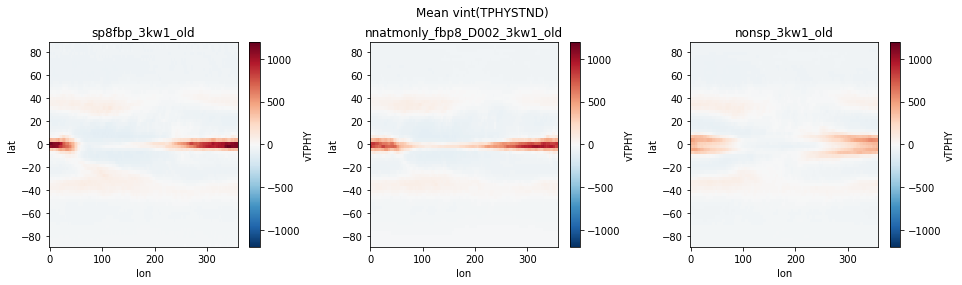

In [70]:
compare(lambda d: d['vTPHY'].sel(time=slice(30, None)).mean(('time')), exps_3kw1,
        vmin=-1200, vmax=1200, cmap='RdBu_r', title='Mean vint(TPHYSTND)');

## Wave activity

## Energy conservation

In [73]:
d = h1s['nnatmonly_fbp8_D004_andkua_allfix']

In [79]:
NNQatm = vint(d, 'NNDQ', 1)
PPQatm = vint(d, 'PPDQ', 1)

In [80]:
NNQsurf = d['NNLHF'] / L_V - d['NNPRECT'] * 1e3
PPQsurf = d['NNLHF'] / L_V - d['PPPRECT'] * 1e3

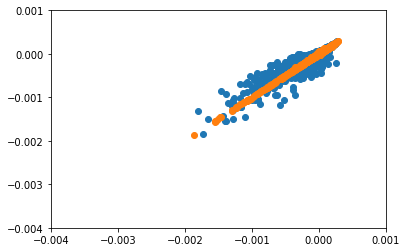

In [81]:
plt.scatter(NNQatm.isel(time=100).values.flat, NNQsurf.isel(time=100).values.flat)
plt.scatter(PPQatm.isel(time=100).values.flat, PPQsurf.isel(time=100).values.flat)
plt.xlim(-4e-3, 1e-3); plt.ylim(-4e-3, 1e-3);

In [85]:
NNSE = vint(d, 'NNDT', C_P) - d['NNSHF'] - d['NNFSNT'] + d['NNFSNS'] + d['NNFLNT'] - d['NNFLNS']
PPSE = vint(d, 'PPDT', C_P) - d['NNSHF'] - d['PPFSNT'] + d['PPFSNS'] + d['PPFLNT'] - d['PPFLNS']

In [86]:
NNME = d['NNLHF'] - vint(d, 'NNDQ', L_V)
PPME = d['NNLHF'] - vint(d, 'PPDQ', L_V)

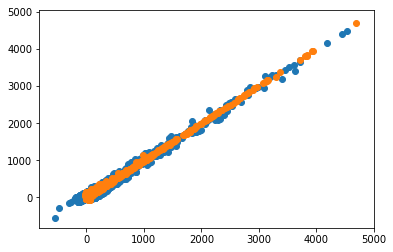

In [87]:
plt.scatter(NNSE.isel(time=100).values.flat, NNME.isel(time=100).values.flat)
plt.scatter(PPSE.isel(time=100).values.flat, PPME.isel(time=100).values.flat)

In [88]:
d_long = xr.open_mfdataset(f'{DATA_DIR}nnatmonly_fbp8_D004_andkua_allfix/*.h0.000*-*', decode_times=False)

In [90]:
h0s['nnatmonly_fbp8_D004_andkua_allfix_long'] = d_long

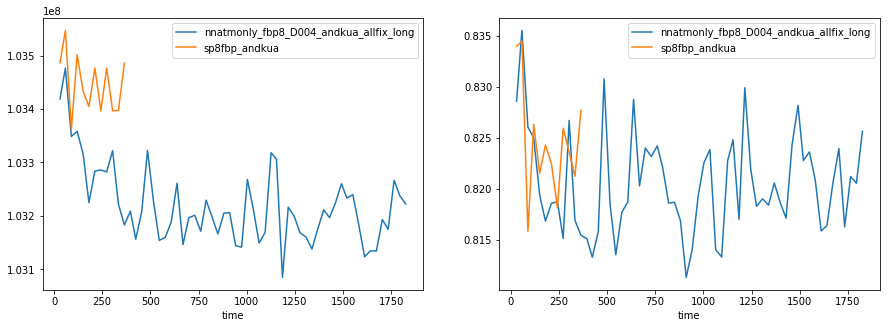

In [92]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
compare_line(lambda d: gw_avg(d, 'TE'), ['nnatmonly_fbp8_D004_andkua_allfix_long'] + [exps_ak[0]], ax=axs[0])
compare_line(lambda d: gw_avg(d, 'TW'), ['nnatmonly_fbp8_D004_andkua_allfix_long'] + [exps_ak[0]], ax=axs[1])